In [1]:
#installing neccesarily libraries
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-m

In [9]:
#import neccessarily libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import DatasetDict

In [3]:
# Function to load and prepare the dataset
def load_and_prepare_data():
    dataset = load_dataset("financial_phrasebank", "sentences_50agree")
    df = pd.DataFrame(dataset['train'])
    return dataset, df


In [4]:
# Function to visualize data distribution
def visualize_data_distribution(df):
    labels = df['label']
    label_counter = Counter(labels)
    plt.figure(figsize=(7, 5))
    sns.barplot(x=list(label_counter.keys()), y=list(label_counter.values()))
    plt.title('Class Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Samples')
    plt.show()

In [5]:
# Function to tokenize dataset
def tokenize_dataset(dataset):
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenized_datasets = dataset.map(lambda examples: tokenizer(examples["sentence"], padding="max_length", truncation=True), batched=True)
    return tokenized_datasets


In [6]:
# Function to split the dataset
def split_data(tokenized_datasets):
    train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.3)
    validation_test_split = train_test_split["test"].train_test_split(test_size=0.5)
    split_datasets = DatasetDict({
        'train': train_test_split['train'],
        'validation': validation_test_split['train'],
        'test': validation_test_split['test']
    })
    return split_datasets

In [7]:
# Function to define and run the model
def define_and_run_model(split_datasets):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
    # # Define training parameters and configurations for the model
    training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    evaluation_strategy="epoch",     # evaluation is done at the end of each epoch
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    num_train_epochs=3,              # number of training epochs
    weight_decay=0.01                # strength of weight decay
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=split_datasets['train'],
        eval_dataset=split_datasets['validation'],
        compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
    )
    trainer.train()
    return trainer

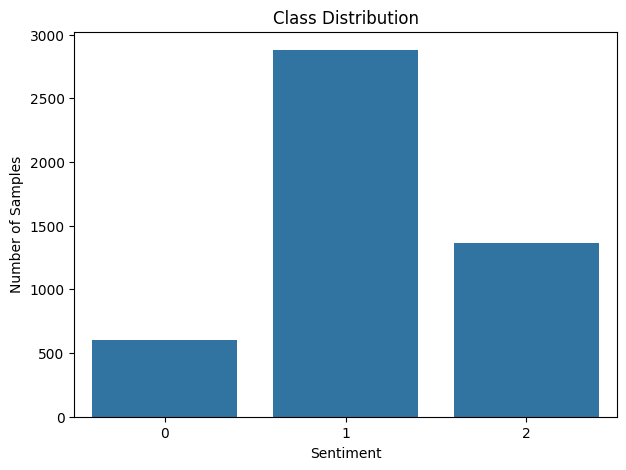

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.430183,0.856946
2,0.553600,0.524751,0.854195
3,0.260500,0.581336,0.865199


{'eval_loss': 0.663798451423645, 'eval_accuracy': 0.8486932599724897, 'eval_runtime': 22.9332, 'eval_samples_per_second': 31.701, 'eval_steps_per_second': 2.006, 'epoch': 3.0}


In [10]:
#call of the functions
dataset, df = load_and_prepare_data()
visualize_data_distribution(df)
tokenized_datasets = tokenize_dataset(dataset)
split_datasets = split_data(tokenized_datasets)
trainer = define_and_run_model(split_datasets)
test_results = trainer.evaluate(split_datasets['test'])
print(test_results)

Overall Assessment:
The model is showing a good balance between accuracy and efficiency, with a decent evaluation runtime and a high accuracy rate.
The loss value, while specific to the scale of your problem, suggests there may be room for improvement, either through further training, hyperparameter tuning, or by using a more complex model architecture.
Consider evaluating the model against a separate test set (if not already done) to ensure these metrics hold up in a completely unseen data scenario. This will help confirm the model's generalizability.
If your dataset is imbalanced or if there are multiple classes, consider looking at additional metrics such as precision, recall, F1-score, and a confusion matrix to get a more nuanced view of model performance across different categories.